In [1]:
# Install required packages
!pip install pandas numpy matplotlib seaborn scipy statsmodels kaggle

# Set up Kaggle credentials
import os
from google.colab import files

# Create .kaggle directory
!mkdir -p ~/.kaggle

# Upload your kaggle.json file
print("Please upload your kaggle.json file")
uploaded = files.upload()
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download datasets from Kaggle
!kaggle datasets download -d carrie1/ecommerce-data
!kaggle datasets download -d theworldbank/world-development-indicators

# Extract e-commerce data
!unzip -o ecommerce-data.zip

# List files to make sure they're downloaded
!ls -la

if not os.path.exists('data.csv'):
    !unzip -q -o ecommerce-data.zip

# Unzip WDI data and extract nested archives
if not os.path.exists('wdi_files'):
    !unzip -q -o world-development-indicators.zip -d wdi_files

Please upload your kaggle.json file


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/carrie1/ecommerce-data
License(s): unknown
Dataset URL: https://www.kaggle.com/datasets/theworldbank/world-development-indicators
License(s): world-bank
Archive:  ecommerce-data.zip
  inflating: data.csv                
total 184592
drwxr-xr-x 1 root root      4096 Apr 24 17:47 .
drwxr-xr-x 1 root root      4096 Apr 24 17:46 ..
drwxr-xr-x 4 root root      4096 Apr 23 13:39 .config
-rw-r--r-- 1 root root  45580638 Sep 20  2019 data.csv
-rw-r--r-- 1 root root   7548686 Sep 20  2019 ecommerce-data.zip
-rw-r--r-- 1 root root        65 Apr 24 17:47 kaggle.json
drwxr-xr-x 1 root root      4096 Apr 23 13:39 sample_data
-rw-r--r-- 1 root root 135866906 Sep 20  2019 world-development-indicators.zip


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os


ecom_df = pd.read_csv('data.csv', encoding='ISO-8859-1')
wdi_df = pd.read_csv('wdi_files/wdi-csv-zip-57-mb-/WDIData.csv')


# Remove rows with missing customer IDs
ecom_df = ecom_df.dropna(subset=['CustomerID'])
# Convert CustomerID to integer
ecom_df['CustomerID'] = ecom_df['CustomerID'].astype(int)
# Convert invoice date to datetime format
ecom_df['InvoiceDate'] = pd.to_datetime(ecom_df['InvoiceDate'])
# Extract the year from invoice date
ecom_df['Year'] = ecom_df['InvoiceDate'].dt.year
# Calculate the total value of each order item
ecom_df['OrderValue'] = ecom_df['Quantity'] * ecom_df['UnitPrice']
# Remove returns and invalid entries (negative quantities or zero prices)
ecom_df = ecom_df[(ecom_df['Quantity'] > 0) & (ecom_df['UnitPrice'] > 0)]


# Create a mapping from original country names to standardized names
# This helps match countries between the datasets
country_mapping = {
    'United Kingdom': 'United Kingdom',
    'EIRE': 'Ireland',
    'Germany': 'Germany',
    'France': 'France',
    'Australia': 'Australia',
    'USA': 'United States',
    'Netherlands': 'Netherlands',
    'Switzerland': 'Switzerland',
    'Belgium': 'Belgium',
    'Spain': 'Spain',
    'Portugal': 'Portugal',
    'Italy': 'Italy',
    'Norway': 'Norway',
    'Finland': 'Finland',
    'Denmark': 'Denmark',
    'Sweden': 'Sweden',
    'Hong Kong': 'Hong Kong SAR, China',
    'Singapore': 'Singapore',
    'Japan': 'Japan',
    'Austria': 'Austria'
}

# Create a new column with standardized country names
ecom_df['StandardCountry'] = ecom_df['Country'].map(country_mapping)

print("\nCalculating average order value by country...")

# Step 1: Find which invoice belongs to which country
invoice_countries = ecom_df[['InvoiceNo', 'StandardCountry']].drop_duplicates()

# Step 2: Calculate the total value of each invoice
invoice_values = ecom_df.groupby('InvoiceNo')['OrderValue'].sum().reset_index()

# Step 3: Combine the invoice values with countries
invoice_data = pd.merge(invoice_values, invoice_countries, on='InvoiceNo')

# Step 4: Calculate the average order value for each country
country_aov = invoice_data.groupby('StandardCountry')['OrderValue'].mean().reset_index()

# Rename the column for clarity
country_aov.rename(columns={'OrderValue': 'AvgOrderValue'}, inplace=True)

# Remove any countries with missing names
country_aov = country_aov.dropna(subset=['StandardCountry'])




# Filter the WDI data to only include GDP per capita
gdp_indicator = 'NY.GDP.PCAP.CD'
gdp_data = wdi_df[wdi_df['Indicator Code'] == gdp_indicator]

# Find the available years in the GDP data
year_columns = [col for col in gdp_data.columns if str(col).isdigit()]
available_years = sorted([int(year) for year in year_columns], reverse=True)

# Create a clean dataframe with just country name and GDP
gdp_clean = gdp_data[['Country Name', str(2011)]].copy()
gdp_clean.columns = ['Country', 'GDP_per_capita']

# Remove rows with missing GDP values
gdp_clean = gdp_clean.dropna(subset=['GDP_per_capita'])

# Merge the average order value with GDP per capita
analysis_data = pd.merge(
    country_aov,
    gdp_clean,
    left_on='StandardCountry',  # Column from e-commerce data
    right_on='Country',         # Column from GDP data
    how='inner'                 # Only keep countries that appear in both datasets
)


# Calculate the correlation coefficient
correlation, p_value = stats.pearsonr(
    analysis_data['GDP_per_capita'],
    analysis_data['AvgOrderValue']
)

print(f"Correlation coefficient: {correlation:.4f}")
print(f"P-value: {p_value:.4f}")

<ipython-input-8-d2d3be237c0a>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ecom_df['CustomerID'] = ecom_df['CustomerID'].astype(int)



Calculating average order value by country...
Correlation coefficient: 0.2311
P-value: 0.3411


<ipython-input-8-d2d3be237c0a>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ecom_df['StandardCountry'] = ecom_df['Country'].map(country_mapping)


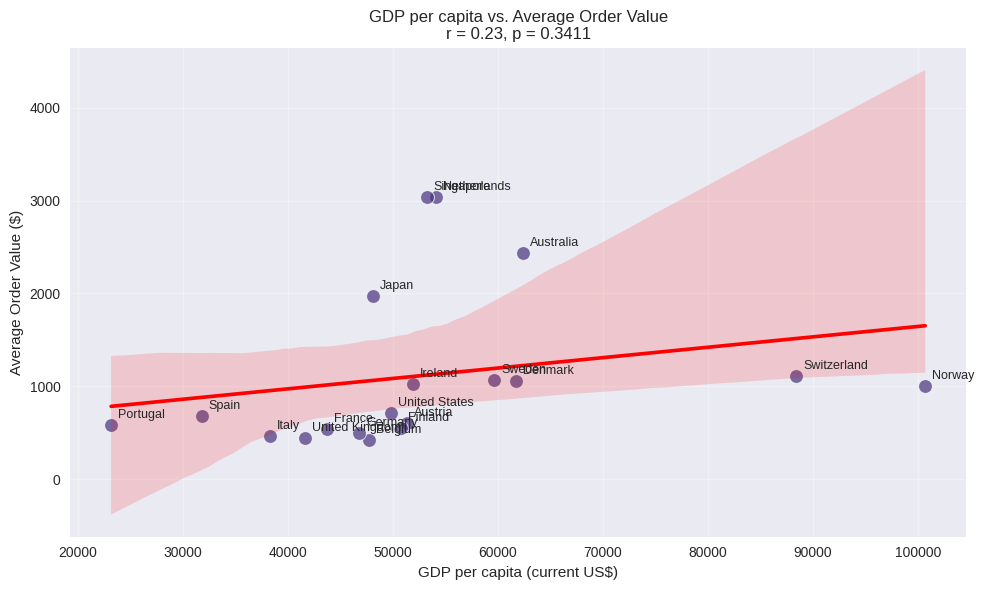


Grouping countries by GDP level...

Average Order Value by GDP Group:
                  mean         std  count
GDP_Group                                
Low         518.357014   93.203856      7
Medium      971.303552  587.176775      5
High       1819.605575  972.194634      7


<ipython-input-9-1b98c0527705>:55: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_stats = analysis_data.groupby('GDP_Group')['AvgOrderValue'].agg(['mean', 'std', 'count'])


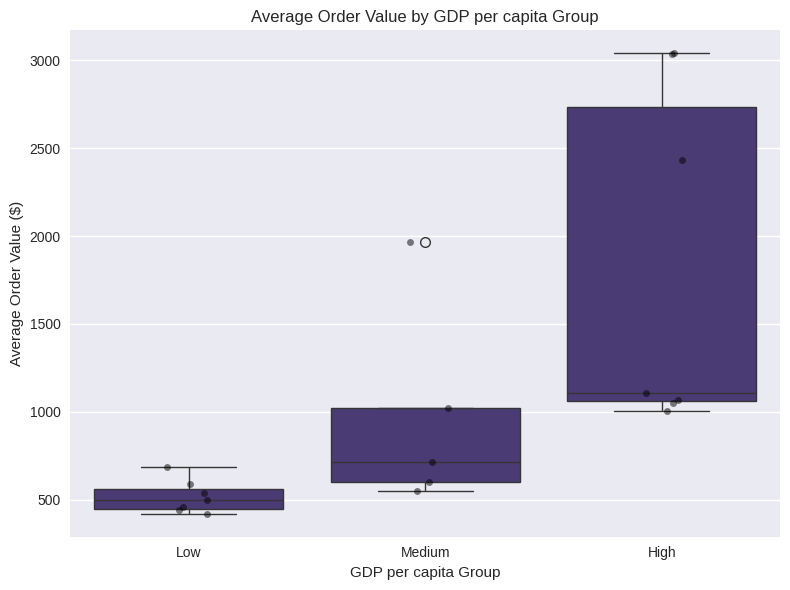

In [9]:
# Create scatter plot
plt.figure(figsize=(10, 6))

# Plot each country as a point
sns.scatterplot(
    data=analysis_data,
    x='GDP_per_capita',
    y='AvgOrderValue',
    s=100,  # Point size
    alpha=0.7  # Transparency
)

# Add a trend line
sns.regplot(
    data=analysis_data,
    x='GDP_per_capita',
    y='AvgOrderValue',
    scatter=False,  # Don't add more points
    color='red'
)

# Add country labels to each point
for i, row in analysis_data.iterrows():
    plt.annotate(
        row['Country'],  # The text to add
        (row['GDP_per_capita'], row['AvgOrderValue']),  # Point coordinates
        xytext=(5, 5),  # Offset text slightly from the point
        textcoords='offset points',
        fontsize=9
    )

# Add title and labels
plt.title(f"GDP per capita vs. Average Order Value\nr = {correlation:.2f}, p = {p_value:.4f}")
plt.xlabel("GDP per capita (current US$)")
plt.ylabel("Average Order Value ($)")
plt.grid(True, alpha=0.3)  # Add light grid lines

plt.tight_layout()
plt.show()

# ==========================================
# STEP 8: GROUP COUNTRIES BY GDP LEVEL
# ==========================================

print("\nGrouping countries by GDP level...")

# Create 3 GDP groups: Low, Medium, High
analysis_data['GDP_Group'] = pd.qcut(
    analysis_data['GDP_per_capita'],
    q=min(3, analysis_data.shape[0]),  # Use fewer groups if we have few countries
    labels=['Low', 'Medium', 'High'][:min(3, analysis_data.shape[0])]
)

# Calculate statistics for each group
group_stats = analysis_data.groupby('GDP_Group')['AvgOrderValue'].agg(['mean', 'std', 'count'])
print("\nAverage Order Value by GDP Group:")
print(group_stats)

# Create box plot to compare groups
plt.figure(figsize=(8, 6))

# Create the boxplot
sns.boxplot(
    data=analysis_data,
    x='GDP_Group',
    y='AvgOrderValue'
)

# Add individual country points
sns.stripplot(
    data=analysis_data,
    x='GDP_Group',
    y='AvgOrderValue',
    color='black',
    alpha=0.5,
    jitter=True  # Add some random noise to avoid overlapping points
)

# Add title and labels
plt.title("Average Order Value by GDP per capita Group")
plt.xlabel("GDP per capita Group")
plt.ylabel("Average Order Value ($)")
plt.tight_layout()
plt.show()

Top 5 countries by number of transactions:
Country
United Kingdom    354321
Germany             9040
France              8341
EIRE                7236
Spain               2484
dtype: int64


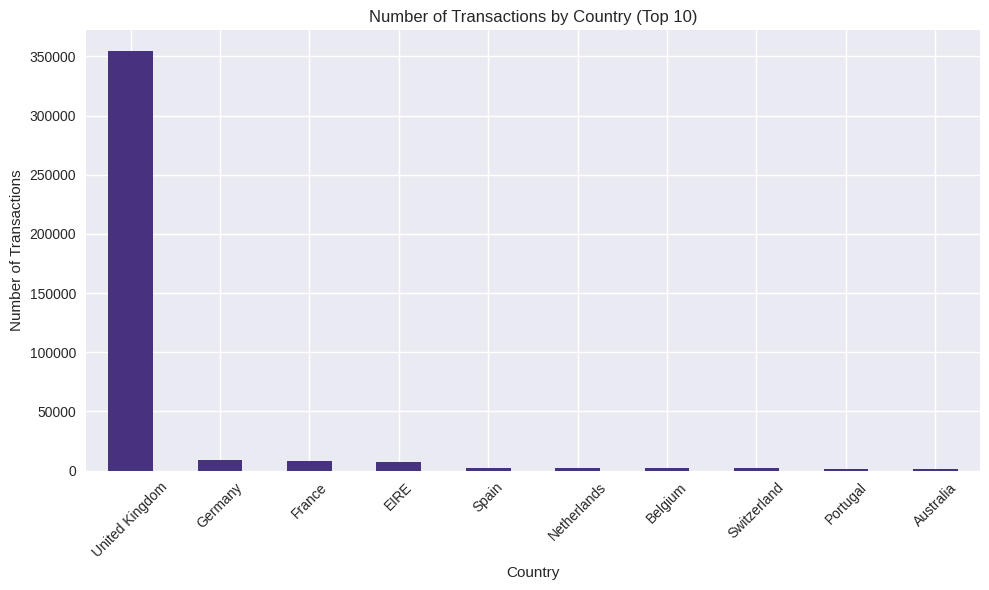

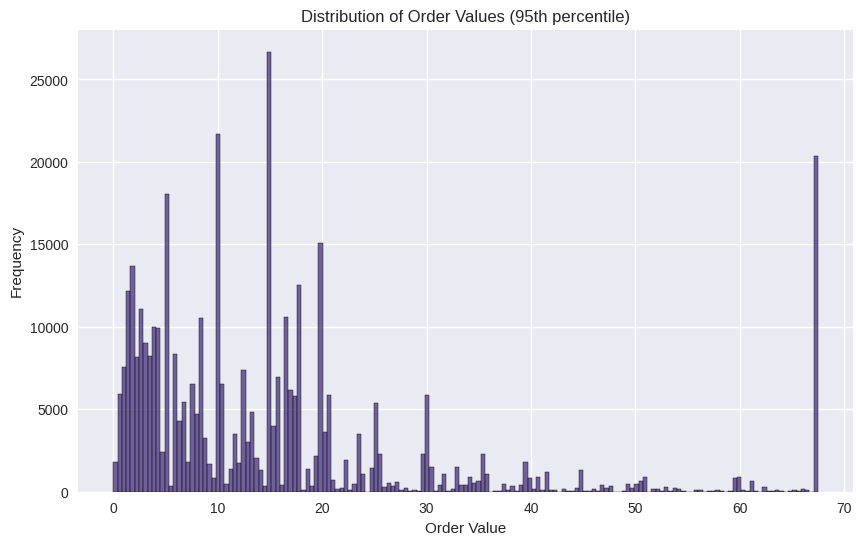

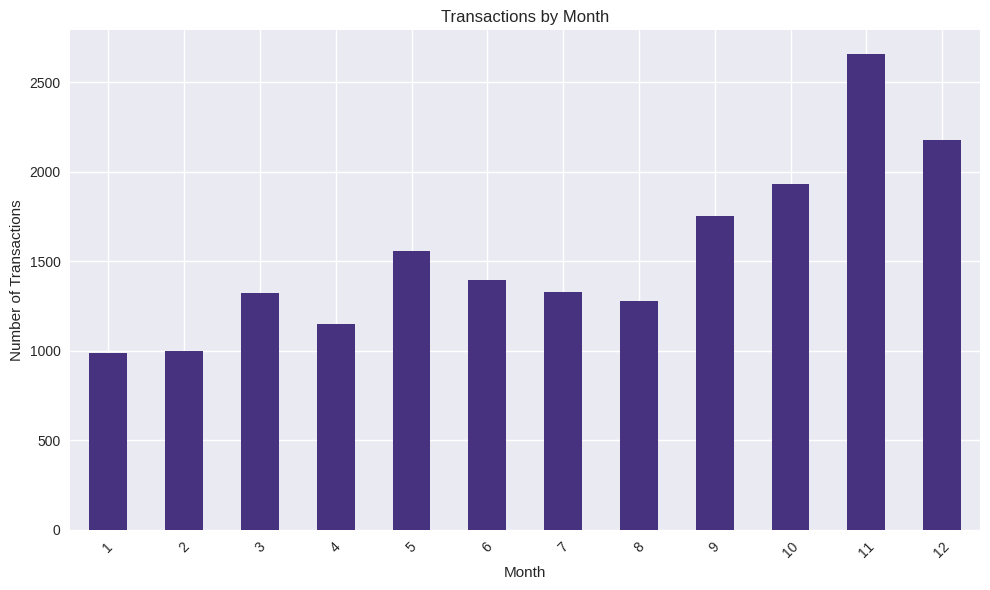

Top 10 countries by GDP per capita:
                 Country  GDP_per_capita
283546            Monaco   162155.498619
257962     Liechtenstein   158283.076260
261160        Luxembourg   115761.507705
310729            Norway   100711.224781
376288       Switzerland    88415.628061
109255           Bermuda    85973.158416
329917             Qatar    85948.070456
225982       Isle of Man    81304.850006
262759  Macao SAR, China    66813.349741
337912        San Marino    65213.618990


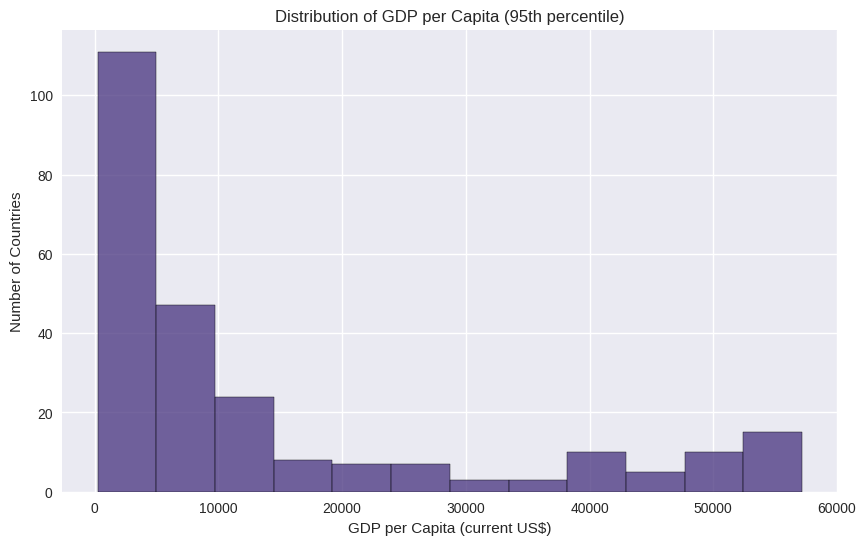

In [16]:
country_counts = ecom_df.groupby('Country').size().sort_values(ascending=False)
print("Top 5 countries by number of transactions:")
print(country_counts.head(5))

# Plot transactions by country
plt.figure(figsize=(10, 6))
country_counts.head(10).plot(kind='bar')
plt.title('Number of Transactions by Country (Top 10)')
plt.xlabel('Country')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Look at order values
plt.figure(figsize=(10, 6))
sns.histplot(ecom_df['OrderValue'].clip(upper=ecom_df['OrderValue'].quantile(0.95)))
plt.title('Distribution of Order Values (95th percentile)')
plt.xlabel('Order Value')
plt.ylabel('Frequency')
plt.show()

# Look at transactions by month
monthly_data = ecom_df.groupby('Month').agg({
    'InvoiceNo': 'nunique',
    'OrderValue': 'sum'
})
monthly_data.columns = ['Transaction Count', 'Total Revenue']

plt.figure(figsize=(10, 6))
monthly_data['Transaction Count'].plot(kind='bar')
plt.title('Transactions by Month')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Get GDP per capita data
gdp_indicator = 'NY.GDP.PCAP.CD'  # GDP per capita (current US$)
gdp_data = wdi_df[wdi_df['Indicator Code'] == gdp_indicator]

# Use 2011 data (from the e-commerce data year)
gdp_clean = gdp_data[['Country Name', '2011']].copy()
gdp_clean.columns = ['Country', 'GDP_per_capita']
gdp_clean = gdp_clean.dropna(subset=['GDP_per_capita'])

# Show top countries by GDP
print("Top 10 countries by GDP per capita:")
print(gdp_clean.sort_values('GDP_per_capita', ascending=False).head(10))

# Plot GDP distribution
plt.figure(figsize=(10, 6))
sns.histplot(gdp_clean['GDP_per_capita'].clip(upper=gdp_clean['GDP_per_capita'].quantile(0.95)))
plt.title('Distribution of GDP per Capita (95th percentile)')
plt.xlabel('GDP per Capita (current US$)')
plt.ylabel('Number of Countries')
plt.show()







